In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import spacy

/Users/krishan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [24]:
data = pd.read_csv('questions.csv')


In [25]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [26]:
data.is_duplicate.value_counts()

0    255045
1    149306
Name: is_duplicate, dtype: int64

## Tasks at our disposal
#### 1. EDA
#### 2. Data Cleaning - Stopwords , Alphanucmeric only
#### 3. Feature Engineering - Vectorizers
#### 4. Model Building - train/test split , initial model. Parameteization with updating model params and corpus methods like vectorizer etc 
#### 5. Model Evaluation - COnfusion matrix , metrics peresicion recall accuracy f1
#### 6. Hosting on streamlit
#### 7. 2 page report
#### 8. Video recording
#### 9. Presentation 15 mins in class

# 1. EDA


In [27]:
#Dataset Shape
print("dataframe shape: ",data.shape)

#null vs not null
data.isnull().sum()

dataframe shape:  (404351, 6)


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [28]:
#remove null values
data = data.dropna()

In [29]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

/var/folders/1p/q_9hhzqs0yddpgkxqm_hvtbc0000gn/T/ipykernel_51367/2612549326.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['length'], color='blue')
/var/folders/1p/q_9hhzqs0yddpgkxqm_hvtbc0000gn/T/ipykernel_51367/2612549326.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['len

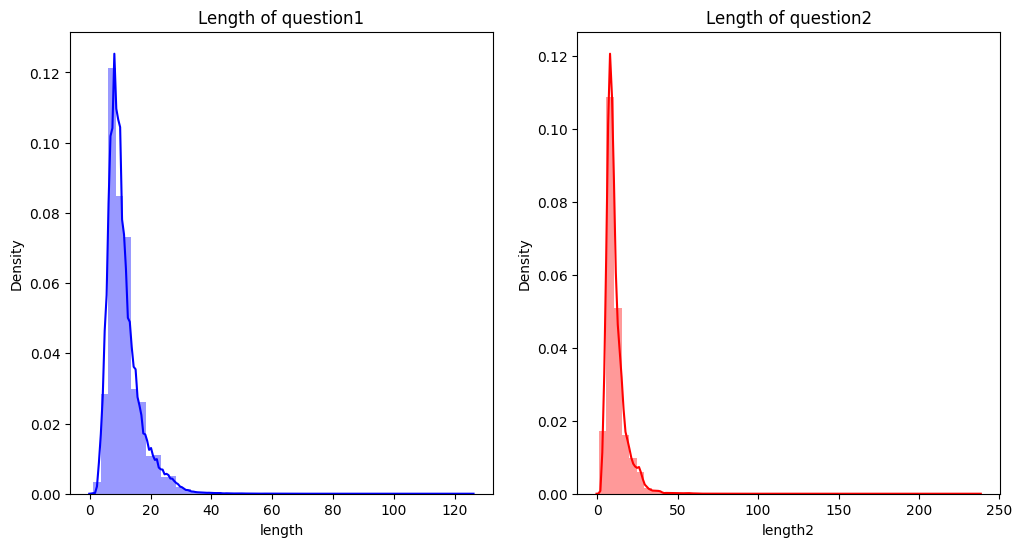

In [31]:
#length of questions
data['length'] = data['question1'].apply(lambda x: len(str(x).split()))
data['length2'] = data['question2'].apply(lambda x: len(str(x).split()))

#plot length of questions
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.distplot(data['length'], color='blue')
plt.title('Length of question1')
plt.subplot(1,2,2)
sns.distplot(data['length2'], color='red')
plt.title('Length of question2')
plt.show()

In [32]:
#merge the questions in one list
questions = list(data['question1']) + list(data['question2'])
len(questions)

808696

Number of unique words:  232563
[('the', 371844), ('What', 292760), ('is', 216206), ('I', 211550), ('a', 208435), ('to', 203421), ('How', 201477), ('in', 190038), ('of', 158592), ('do', 139504)]


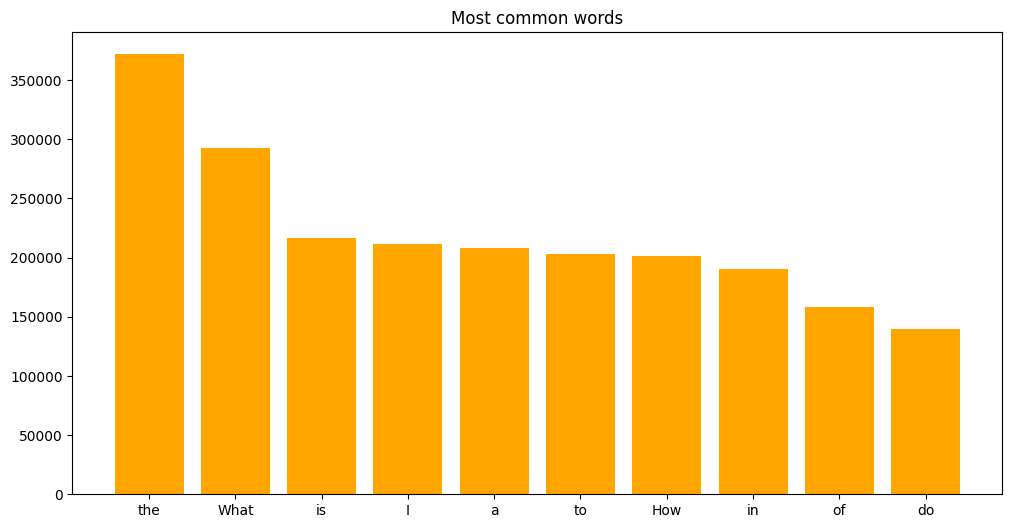

In [36]:
#find number of unique words
unique_words = len(set(" ".join(questions).split()))
print("Number of unique words: ", unique_words)

#printing the most common words 
from collections import Counter
cnt = Counter()
for word in questions:
    cnt.update(word.split())
print(cnt.most_common(10))

#plot
most_common = cnt.most_common(10)
most_common = dict(most_common)
plt.figure(figsize=(12, 6))
plt.bar(most_common.keys(), most_common.values(), color='orange')
plt.title('Most common words')
plt.show()


# 2. Data Cleaning

#### Basic Cleaning

In [17]:
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to expand contractions
def expand_contractions(text):
    # Dictionary of English contractions
    contractions_dict = {"don't": "do not", "doesn't": "does not", "didn't": "did not",
                         # Add more contractions as needed
                        }
    # Regular expression for finding contractions
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]

    return contractions_re.sub(replace, text)

#function to handle LaTeX expressions
def clean_math_text(text):

    replacements = {
        # Basic operations and structures
        r'\\frac\{(.*?)\}\{(.*?)\}': r'\1 over \2',
        r'\\sqrt\{(.*?)\}': r'square root of \1',
        r'\\sum_(\{.*?\})\^(\{.*?\})': r'sum from \1 to \2',
        r'\\int_(\{.*?\})\^(\{.*?\})': r'integral from \1 to \2',
        r'\\log_(\{.*?\})\{(.*?)\}': r'log base \1 of \2',
        r'\\lim_(\{.*?\})': r'limit as \1',
        r'(\d+)\^(\{?\d+\}?)': r'\1 to the power of \2',
        r'\\infty': 'infinity',
        r'\\pm': 'plus or minus',
        # Greek letters
        r'\\alpha': 'alpha', r'\\beta': 'beta', r'\\gamma': 'gamma',
        r'\\delta': 'delta', r'\\epsilon': 'epsilon', r'\\zeta': 'zeta',
        r'\\eta': 'eta', r'\\theta': 'theta', r'\\iota': 'iota',
        r'\\kappa': 'kappa', r'\\lambda': 'lambda', r'\\mu': 'mu',
        r'\\nu': 'nu', r'\\xi': 'xi', r'\\omicron': 'omicron',
        r'\\pi': 'pi', r'\\rho': 'rho', r'\\sigma': 'sigma',
        r'\\tau': 'tau', r'\\upsilon': 'upsilon', r'\\phi': 'phi',
        r'\\chi': 'chi', r'\\psi': 'psi', r'\\omega': 'omega',
        # Trigonometric functions
        r'\\sin': 'sine', r'\\cos': 'cosine', r'\\tan': 'tangent',
        r'\\csc': 'cosecant', r'\\sec': 'secant', r'\\cot': 'cotangent',
        # Differential and partial differential
        r'\\partial': 'partial', r'\\nabla': 'nabla',
        r'\\mathrm\{d\}': 'd',  # For derivatives
        # Other mathematical symbols
        r'\\times': 'times', r'\\div': 'divided by', r'\\cdot': 'dot',
        # Additional symbols and operations
        r'\+': 'plus', r'\-': 'minus', r'\*': 'times',
        # Handling general exponentiation
        r'\\exp\{(.*?)\}': r'e to the power of \1',  # For exponential functions
        r'(\w+)\^(\w+)': r'\1 to the power of \2',  # General exponentiation
        # Handling \mathop
        r'\\mathop\{\\rm ([^}]+)\}': r'operator \1'    }
    
    # Function to apply replacements to a matched object
    def apply_replacements(match):
        # Extracting the matched text excluding the [math] tags
        math_text = match.group(1) # match.group(0) includes the whole match, so match.group(1) is the first capture group
        
        # Applying all replacements to the math_text
        for pattern, replacement in replacements.items():
            math_text = re.sub(pattern, replacement, math_text)
        
        # Return the transformed math_text
        return math_text

    # Use=ing re.sub with a function that applies the replacements for each [math] section
    # Pattern captures the content between [math] and [/math] tags
    pattern = r'\[math\](.*?)\[/math\]'
    clean_text = re.sub(pattern, apply_replacements, text)

    # Removing unnecessary braces and cleanup, applied globally to the whole text
    clean_text = re.sub(r'\{|\}', '', clean_text)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text

# Function to clean text
def clean_text(text):
    #handling LaTex expressions
    text = clean_math_text(text)
    # Lowercase conversion
    text = text.lower()
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Expanding contractions
    text = expand_contractions(text)
    # Removing special characters
    text = re.sub(r'\W', ' ', text)
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # removing stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Applying the cleaning function to DataFrame
data['clean_question1'] = data['question1'].apply(clean_text)
data['clean_question2'] = data['question2'].apply(clean_text)

#dropping the original columns
data.drop(['question1', 'question2'], axis=1, inplace=True)

# Displaying the cleaned dataset
data.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandaniyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,qid1,qid2,is_duplicate,clean_question1,clean_question2
0,0,1,2,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,0,mentally lonely solve,find remainder 23 power 24 divided 24 23
4,4,9,10,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water


#### Lemmatization using SpaCy

In [22]:
# Loading spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_list = [token.lemma_ for token in doc if token.is_alpha]
    
    return ' '.join(lemmatized_list)

data['clean_question1'] = data['clean_question1'].apply(lemmatize_text)
data['clean_question2'] = data['clean_question2'].apply(lemmatize_text)

#### Lemmatization using NLTK

 part of speech (POS) tagging is necessary for lemmatization in NLTK, especially in our use case of comparing questions to determine duplicates. The reason is that NLTK's lemmatization depends on POS tags to correctly identify the base form of words. Different words require different lemmatization processes based on their POS (e.g., verbs, nouns, adjectives). Without POS tagging, lemmatization may not accurately reduce words to their base or dictionary form, which could affect the comparison and analysis of question pairs for duplicates.

In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

# Function to convert NLTK tag to WordNet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(sentence)
    pos_tagged = nltk.pos_tag(tokens)
    lemmatized_sentence = []
    for word, tag in pos_tagged:
        wordnet_tag = nltk_tag_to_wordnet_tag(tag)
        if wordnet_tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, wordnet_tag))
        else:
            lemmatized_sentence.append(word)
    return ' '.join(lemmatized_sentence)

# Read the dataset
df = pd.read_csv('/mnt/data/cleaned_questions.csv')

# Apply lemmatization to each question
df['lemmatized_question1'] = df['clean_question1'].apply(lemmatize_sentence)
df['lemmatized_question2'] = df['clean_question2'].apply(lemmatize_sentence)


In [ ]:
#saving cleaned file as csv
data.to_csv('cleaned_questions.csv', index=False)

## Reading the cleaned data from csv

In [10]:
#read cleaned file
data = pd.read_csv('cleaned_questions.csv')
data.head()

,id,qid1,qid2,is_duplicate,clean_question1,clean_question2
0,0,1,2,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,0,mentally lonely solve,find remainder 23 power 24 divided 24 23
4,4,9,10,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [13]:
# LEmatizing
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemma = WordNetLemmatizer()
def lemmatize_text(text):
    # Convert non-string input to string
    text_str = str(text)
    return [lemma.lemmatize(word) for word in text_str.split()]

data['clean_question1'] = data['clean_question1'].apply(lemmatize_text)
data['clean_question2'] = data['clean_question2'].apply(lemmatize_text)



[nltk_data] Downloading package wordnet to /Users/krishan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# convert lemmatized text to string
data['clean_question1'] = data['clean_question1'].apply(lambda x: ' '.join(x))
data['clean_question2'] = data['clean_question2'].apply(lambda x: ' '.join(x))

data.head()

,id,qid1,qid2,is_duplicate,clean_question1,clean_question2
0,0,1,2,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,5,6,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,7,8,0,mentally lonely solve,find remainder 23 power 24 divided 24 23
4,4,9,10,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water


## 3.1 Vectorising using TFIDF

In [18]:
#vecoring the q1 and q2
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_q1 = tfidf.fit_transform(data['clean_question1'])
tfidf_q2 = tfidf.transform(data['clean_question2'])

tfidf_q1.shape, tfidf_q2.shape

((404348, 61575), (404348, 61575))

In [20]:
#printing a single vecotor of q1

print(data['clean_question1'][0])
print(tfidf_q1[0],"\n")


print(data['clean_question1'][1])
print(tfidf_q1[1])

step step guide invest share market india
  (0, 27827)	0.20260669546898416
  (0, 34288)	0.3135977989807102
  (0, 49562)	0.33669490842963884
  (0, 28782)	0.3355128116117277
  (0, 24514)	0.4049453322792551
  (0, 52147)	0.6860713644897201 

story kohinoor koh noor diamond
  (0, 16778)	0.3999898295991467
  (0, 38519)	0.5252749978327631
  (0, 31190)	0.4855577406390672
  (0, 31193)	0.4952300526142563
  (0, 52337)	0.28822766758623536


## 3.2 Vectorising using Word2Vec

In [21]:
#vecotorising using word2vec
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

#tokenizing the questions
data['q1_tokens'] = data['clean_question1'].apply(lambda x: word_tokenize(x))
data['q2_tokens'] = data['clean_question2'].apply(lambda x: word_tokenize(x))

data.head()


,id,qid1,qid2,is_duplicate,clean_question1,clean_question2,q1_tokens,q2_tokens
0,0,1,2,0,step step guide invest share market india,step step guide invest share market,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,0,increase speed internet connection using vpn,internet speed increased hacking dns,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,0,mentally lonely solve,find remainder 23 power 24 divided 24 23,"[mentally, lonely, solve]","[find, remainder, 23, power, 24, divided, 24, 23]"
4,4,9,10,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [22]:
# Combining tokens from q1 and q2 for training the Word2Vec model
combined_tokens = data['q1_tokens'].tolist() + data['q2_tokens'].tolist()

# Training the Word2Vec model
model = Word2Vec(combined_tokens, vector_size=100, window=5, min_count=1, workers=4)
model.train(combined_tokens, total_examples=model.corpus_count, epochs=10)

# Adjusting the get_average_word2vec function to work with the vector model and tokens
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list) < 1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# Adjusting the get_word2vec_embeddings function to handle both q1 and q2
def get_word2vec_embeddings(vectors, tokens):
    embeddings = tokens.apply(lambda x: get_average_word2vec(x, vectors))
    return list(embeddings)

# Applying the function to get the Word2Vec embeddings for both questions
q1_embeddings = get_word2vec_embeddings(model.wv, data['q1_tokens'])
q2_embeddings = get_word2vec_embeddings(model.wv, data['q2_tokens'])

# Verifying the shape of the embeddings
np.array(q1_embeddings).shape, np.array(q2_embeddings).shape

((404348, 100), (404348, 100))

In [23]:
#printing the embeddings

print(data['clean_question1'][0])
print(data['q1_tokens'][0])
print(q1_embeddings[0],"\n")

step step guide invest share market india
['step', 'step', 'guide', 'invest', 'share', 'market', 'india']
[ 0.62592524  0.37922192 -0.26879168 -0.03520905  0.71771127  0.16768709
  0.1270267  -0.04300409 -0.80732054 -0.09386255  0.58032984 -0.14728515
  0.11337805 -0.1010804  -0.2924793   0.11187453 -1.0687002  -0.19204631
  0.37096325  0.12307853 -0.69781977 -0.9117969  -0.9573948   0.05810999
 -1.2984778  -0.01399626 -0.3142688   0.71055895  0.03281112 -0.8383918
 -0.14864115  0.5552698   0.25287846 -0.08621379 -1.5034295  -1.5006145
 -0.4421868  -0.8827043   0.7976157   0.4338695  -0.06591369 -0.441313
  0.56675345 -0.5752734  -0.81129044  0.27201834 -0.08029526 -2.127949
 -0.254287    0.6414986  -0.4497859  -0.3746397   1.3418857   1.3775836
  0.72208554 -1.1153908  -1.3043991   0.2774089  -0.6302806  -0.47262844
  0.03970897  0.5976429  -0.21785203  1.2186329   0.7440583  -1.1286119
  0.06018786 -1.5909938   0.53716004 -0.6144041   0.11887737  0.7582375
 -0.20170198 -0.63883066  0